# Tensor Flow Quantum

TensorFlow Quantum фокусируется на квантовых данных и построении гибридных квантово-классических моделей . Он предоставляет инструменты для чередования квантовых алгоритмов и логики, разработанных в Cirq с помощью TensorFlow. 

TensorFlow Quantum предоставляет следующие операции:

- Выборка из выходных распределений пакетов схем.
- Рассчитайте математическое ожидание пакетов сумм Паули по пакетам схем. TFQ реализует **вычисление градиента, совместимое с обратным распространением**.
- Моделируйте пакеты схем и состояний(все $2^n$ комплексных амплитуд). 

То есть можно совмещать с помощью нее обычные блоки и квантовые. Градиент будет пропускаться.


### Под копотом у нее Cirq от того же гугла.

Cirq is a Python software library for writing, manipulating, and optimizing quantum circuits, and then running them on quantum computers and quantum simulators. Cirq provides useful abstractions for dealing with today’s noisy intermediate-scale quantum computers, where details of the hardware are vital to achieving state-of-the-art results.

То есть можно собрать, убрать позапускать на симуляторе, а потом сразу задеплоить в настоящий квантовый комп. 
<!-- 
Используемый симулятор: qsim -->

Работает максимум с python 3.9, так что в colab например запустить проблематично.

In [1]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

2023-06-03 12:41:34.834267: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-03 12:41:34.834306: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-06-03 12:41:37.207236: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-06-03 12:41:37.207297: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-06-03 12:41:37.207325: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (amir-asus): /proc/driver/nvidia/version does not exist
2023-06-03 12:41:37.207640: I tensorflow/core/platform/cpu_feature_

В `cirq` можно создавать произвольные схемы с кубитами, в том числе параметризованные.

In [3]:
a, b, c = sympy.symbols('a b c')

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


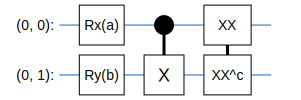

In [4]:
# Create two qubits
q0, q1 = cirq.GridQubit.rect(1, 2)

# Create a circuit on these qubits using the parameters you created above.
circuit = cirq.Circuit(
    cirq.rx(a).on(q0),
    cirq.ry(b).on(q1), cirq.CNOT(control=q0, target=q1),
    cirq.XXPowGate()(q0, q1)**c)

SVGCircuit(circuit)

Моделирует output вектор в виде комплексных амплитуд, а потом умеет считать по нему матожидания комбинаций паули gates

In [5]:
resolver = cirq.ParamResolver({a: 0.5, b: -0.5, c: 0.2})
output_state_vector = cirq.Simulator().simulate(circuit, resolver).final_state_vector
output_state_vector

array([ 0.7786948 +0.25301328j, -0.19883345-0.0646049j ,
       -0.04087932+0.12581362j,  0.1600964 -0.49272606j], dtype=complex64)

In [6]:
qubit_map={q0: 0, q1: 1}

z0x1 = 0.5 * cirq.Z(q0) + cirq.X(q1)

z0x1.expectation_from_state_vector(output_state_vector, qubit_map).real

-0.2653355449438095

Можно задать параметры не просто числами, а tensorFlow тензором. И результат измерений конвертировать в тензор. И пропускать градиенты через квантовую схему.

! ограниченный набор поддерживаемых для интеграции с TensorFlow гейтов.

In [3]:
tfq.util.get_supported_gates()

{cirq.X: 1,
 cirq.XX: 2,
 cirq.Y: 1,
 cirq.YY: 2,
 cirq.Z: 1,
 cirq.ZZ: 2,
 cirq.H: 1,
 cirq.CZ: 2,
 cirq.CNOT: 2,
 cirq.SWAP: 2,
 cirq.ISWAP: 2,
 cirq.PhasedXPowGate(phase_exponent=0.123): 1,
 cirq.PhasedISwapPowGate(phase_exponent=0.123): 2,
 cirq.FSimGate(theta=0.123, phi=0.456): 2,
 cirq.I: 1}

### Пример гибридной схемы
<img src="https://www.tensorflow.org/quantum/tutorials/images/nn_control1.png" width="1000">

In [25]:
# Parameters that the classical NN will feed values into.
control_params = sympy.symbols('theta_1 theta_2 theta_3')

# Create the parameterized circuit.
qubit = cirq.GridQubit(0, 0)
model_circuit = cirq.Circuit(
    cirq.rz(control_params[0])(qubit),
    cirq.ry(control_params[1])(qubit),
    cirq.rx(control_params[2])(qubit))
print(model_circuit)
# The classical neural network layers.
controller = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='elu'),
    tf.keras.layers.Dense(3)
])
# This input is the simulated miscalibration that the model will learn to correct.
circuits_input = tf.keras.Input(shape=(),
                                # The circuit-tensor has dtype `tf.string` 
                                dtype=tf.string,
                                name='circuits_input')

# Commands will be either `0` or `1`, specifying the state to set the qubit to.
commands_input = tf.keras.Input(shape=(1,),
                                dtype=tf.dtypes.float32,
                                name='commands_input')

dense_2 = controller(commands_input)

# TFQ layer for classically controlled circuits.
expectation_layer = tfq.layers.ControlledPQC(model_circuit,
                                             # Observe Z
                                             operators = cirq.Z(qubit))
expectation = expectation_layer([circuits_input, dense_2])
# The full Keras model is built from our layers.
model = tf.keras.Model(inputs=[circuits_input, commands_input],
                       outputs=expectation)
# The command input values to the classical NN.
commands = np.array([[0], [1]], dtype=np.float32)

# The desired Z expectation value at output of quantum circuit.
expected_outputs = np.array([[1], [-1]], dtype=np.float32)

(0, 0): ───Rz(theta_1)───Ry(theta_2)───Rx(theta_3)───


In [13]:
random_rotations = np.random.uniform(0, 2 * np.pi, 3)
noisy_preparation = cirq.Circuit(
  cirq.rx(random_rotations[0])(qubit),
  cirq.ry(random_rotations[1])(qubit),
  cirq.rz(random_rotations[2])(qubit)
)
datapoint_circuits = tfq.convert_to_tensor([
  noisy_preparation
] * 2)  # Make two copied of this circuit

In [14]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
loss = tf.keras.losses.MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss)
history = model.fit(x=[datapoint_circuits, commands],
                    y=expected_outputs,
                    epochs=30,
                    verbose=0)

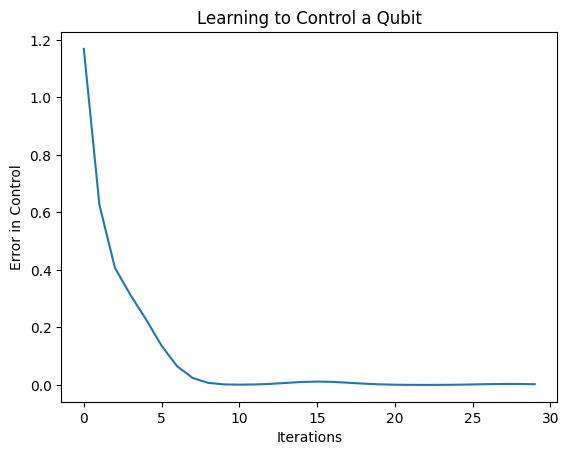

In [15]:
plt.plot(history.history['loss'])
plt.title("Learning to Control a Qubit")
plt.xlabel("Iterations")
plt.ylabel("Error in Control")
plt.show()

## Подробнее о градиентах

В примере выше по умолчанию использовался аналитический расчет expect_value И еще сверху ParameterShift техника.

можно также использовать маленькое приращение.

и можно для большего приближения к реальному использованию считать градиент основываясь на sampling. Тут уже лучше использовать ParameterShift.

In [21]:
qubit = cirq.GridQubit(0, 0)
my_circuit = cirq.Circuit(cirq.Y(qubit)**sympy.Symbol('alpha'))
pauli_x = cirq.X(qubit)
input_points = np.linspace(0, 5, 200)[:, np.newaxis].astype(np.float32)


In [22]:
sampled_expectation_calculation = tfq.layers.SampledExpectation(
    differentiator=tfq.differentiators.ForwardDifference(grid_spacing=0.1))
expectation_calculation = tfq.layers.Expectation(
    differentiator=tfq.differentiators.ForwardDifference(grid_spacing=0.01))


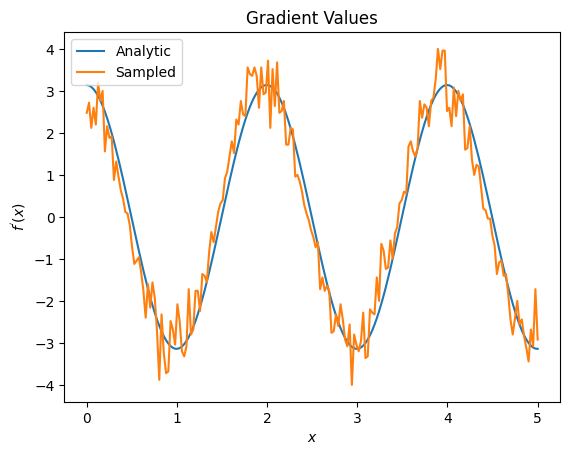

In [23]:
# Gradients are a much different story.
values_tensor = tf.convert_to_tensor(input_points)

with tf.GradientTape() as g:
    g.watch(values_tensor)
    exact_outputs = expectation_calculation(my_circuit,
                                            operators=pauli_x,
                                            symbol_names=['alpha'],
                                            symbol_values=values_tensor)
analytic_finite_diff_gradients = g.gradient(exact_outputs, values_tensor)

with tf.GradientTape() as g:
    g.watch(values_tensor)
    imperfect_outputs = sampled_expectation_calculation(
        my_circuit,
        operators=pauli_x,
        repetitions=500,
        symbol_names=['alpha'],
        symbol_values=values_tensor)
sampled_finite_diff_gradients = g.gradient(imperfect_outputs, values_tensor)

plt.title('Gradient Values')
plt.xlabel('$x$')
plt.ylabel('$f^{\'}(x)$')
plt.plot(input_points, analytic_finite_diff_gradients, label='Analytic')
plt.plot(input_points, sampled_finite_diff_gradients, label='Sampled')
plt.legend()

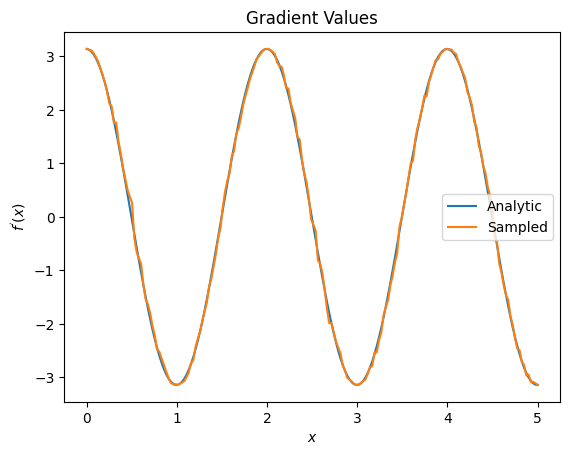

In [24]:
# A smarter differentiation scheme.
gradient_safe_sampled_expectation = tfq.layers.SampledExpectation(
    differentiator=tfq.differentiators.ParameterShift())

with tf.GradientTape() as g:
    g.watch(values_tensor)
    imperfect_outputs = gradient_safe_sampled_expectation(
        my_circuit,
        operators=pauli_x,
        repetitions=500,
        symbol_names=['alpha'],
        symbol_values=values_tensor)

sampled_param_shift_gradients = g.gradient(imperfect_outputs, values_tensor)

plt.title('Gradient Values')
plt.xlabel('$x$')
plt.ylabel('$f^{\'}(x)$')
plt.plot(input_points, analytic_finite_diff_gradients, label='Analytic')
plt.plot(input_points, sampled_param_shift_gradients, label='Sampled')
plt.legend()

### Parameter Shift

first introduced to quantum machine learning in [Mitarai et al. (2018)](https://arxiv.org/abs/1803.00745 "‌"), and extended in [Schuld et al. (2018)](https://arxiv.org/abs/1811.11184 "‌").

$$\nabla_{\theta_i}\mathcal{M}_{\theta_i}(\hat{B}) = c[\mathcal{M}_{\theta_i + s}(\hat{B}) - \mathcal{M}_{\theta_i - s}(\hat{B})],$$

Например для паули гейта \
$|\alpha⟩ = Y^{\alpha}|0⟩$ \
$f(\alpha) = ⟨\alpha|X|\alpha⟩$

$$\frac{\partial}{\partial \alpha} f(\alpha) = \frac{\pi}{2} f\left(\alpha + \frac{1}{2}\right) -  \frac{ \pi}{2} f\left(\alpha - \frac{1}{2}\right)$$

Это все справедливо для гейтов, чей генератор имеет только два собственных значения. То есть все однокубитные вращения. А также некоторые другие "hardware efficient"

$\begin{aligned} \operatorname{ExpW}(\mu, \delta) & =\exp \left(-i \mu\left(\cos (\delta) \sigma_x+\sin (\delta) \sigma_y\right)\right) \\ \operatorname{ExpZ}(\mu) & =\exp \left(-i \mu \sigma_z\right) \\ \operatorname{Exp} 11(\mu) & =\exp (-i \mu|11\rangle\langle 11|)\end{aligned}$

Многокубитные паули вращения в общем случае не подходят...

В таком случае всегда можно посчитать градиент с помощью дополнительного кубита.

### Ancilla qubit 
Утверждается ([PennyLane paper about gradients (2018)](https://arxiv.org/pdf/1811.11184.pdf)), что матрицу производной можно разложить в линейную комбинацию унитарных матриц

$$
\partial_\mu \mathcal{G}=\frac{\alpha}{2}\left(\left(A_1+A_1^{\dagger}\right)+i\left(A_2+A_2^{\dagger}\right)\right)
$$
И с помощью такой схемы с дополнительным кубитом можно измерить действие либо $\mathcal{G} + A$, либо  $\mathcal{G} - A$ в зависимости от значения вспомогательного кубита. А из этого уже считается нужное для производной выражение.

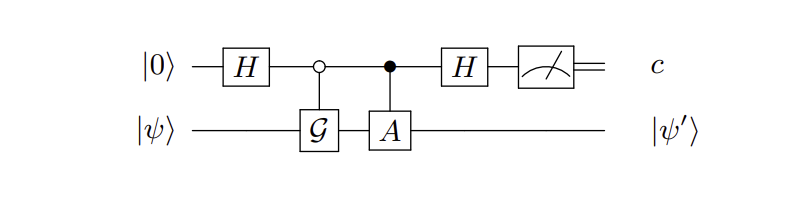


## Real QPU

Поддерживает эмуляцию реальных моделей QC с ограничениями на соединения, количество gate-ов.

In [26]:
import cirq
import cirq_google
import networkx as nx

my_device = cirq_google.Sycamore
print(my_device)

                                             (0, 5)───(0, 6)
                                             │        │
                                             │        │
                                    (1, 4)───(1, 5)───(1, 6)───(1, 7)
                                    │        │        │        │
                                    │        │        │        │
                           (2, 3)───(2, 4)───(2, 5)───(2, 6)───(2, 7)───(2, 8)
                           │        │        │        │        │        │
                           │        │        │        │        │        │
                  (3, 2)───(3, 3)───(3, 4)───(3, 5)───(3, 6)───(3, 7)───(3, 8)───(3, 9)
                  │        │        │        │        │        │        │        │
                  │        │        │        │        │        │        │        │
         (4, 1)───(4, 2)───(4, 3)───(4, 4)───(4, 5)───(4, 6)───(4, 7)───(4, 8)───(4, 9)
         │        │        │        │        │        │   

### Экспорт на реальные устройства от производителей:
(https://quantumai.google/cirq/hardware)
- Alpine Quantum Technologies
- Microsoft Azure Quantum
- IonQ
- Pasqal (100 qubits без подробностей о качестве (тестово даже [300+](https://www.pasqal.com/articles/pasqal-unveils-a-new-quantum-processor-architecture-with-a-record-324-atoms) каких-то ionTrapped кубитов ))
- Rigetti

## Mixed state noisy simulations
[link](https://colab.research.google.com/github/quantumlib/Cirq/blob/master/docs/simulate/noisy_simulation.ipynb#scrollTo=HYkRhx2pe2XX)
In addition to pure state simulation, Cirq also supports simulation of mixed states.

Even though this simulator is not as efficient as the pure state simulators, they allow for a larger class of noisy circuits to be run as well as keeping track of the simulation's density matrix. This fact can allow for more exact simulations: the density matrix can represent all possible results of a noisy circuit, while the pure-state simulator can only sample from these results.

Mixed state simulation is supported by the cirq.DensityMatrixSimulator class.




This formalism models evolution of the density matrix $\rho$ via

$$
\rho \rightarrow \sum_{k = 1}^{m} A_k \rho A_k^\dagger
$$

where $A_k$ are known as *Kraus operators*. These operators are not necessarily unitary but must satisfy the trace-preserving property

$$
\sum_k A_k^\dagger A_k = I .
$$


In [7]:
q = cirq.NamedQubit('a')
circuit = cirq.Circuit(cirq.H(q), cirq.amplitude_damp(0.2)(q), cirq.measure(q))
simulator = cirq.DensityMatrixSimulator()
result = simulator.run(circuit, repetitions=100)
print(result.histogram(key='a'))

Counter({0: 52, 1: 48})


За счет `cirq.amplitude_damp(0.2)(q)` вместо 50% вероятности получается что-то около 60%. 0.2 -- вероятность диссипации энергии.

In [6]:
q = cirq.NamedQubit('a')
circuit = cirq.Circuit(cirq.H(q), cirq.amplitude_damp(0.2)(q))
simulator = cirq.DensityMatrixSimulator()
result = simulator.simulate(circuit)
print("Full density matrix")
print(np.around(result.final_density_matrix, 3))

Full density matrix
[[0.6  +0.j 0.447+0.j]
 [0.447+0.j 0.4  +0.j]]


Или можно bitFlip error сделать вот так:

$$
\rho \rightarrow (1 - p) \rho + p X \rho X
$$

In [9]:
# Apply the channel to each qubit in a circuit.
circuit = cirq.Circuit(bit_flip.on_each(cirq.LineQubit.range(3)))
print(circuit)

0: ───BF(0.1)───

1: ───BF(0.1)───

2: ───BF(0.1)───


Доступны также 
* `cirq.phase_flip`
* `cirq.phase_damp`
* `cirq.amplitude_damp`
* `cirq.depolarize`
* `cirq.asymmetric_depolarize`
* `cirq.reset`

А можно разом добавить во всю схему (после каждого гейта) шум с помощью `with_noise`

In [ ]:
"""One method to insert noise in a circuit."""
# Define some noiseless circuit.
circuit = cirq.testing.random_circuit(qubits=3, n_moments=3, op_density=1, random_state=11)

# Display the noiseless circuit.
print("Circuit without noise:")
print(circuit)

# Add noise to the circuit.
noisy = circuit.with_noise(cirq.depolarize(p=0.01))

# Display it.
print("\nCircuit with noise:")
print(noisy)

Circuit without noise:
              ┌──┐
0: ───@───X─────×────
      │   │     │
1: ───@───┼────S┼────
          │     │
2: ───Z───@─────×────
              └──┘

Circuit with noise:
                                                                        ┌──┐
0: ───@───D(0.01)[cirq.VirtualTag()]───X───D(0.01)[cirq.VirtualTag()]─────×────D(0.01)[cirq.VirtualTag()]───
      │                                │                                  │
1: ───@───D(0.01)[cirq.VirtualTag()]───┼───D(0.01)[cirq.VirtualTag()]────S┼────D(0.01)[cirq.VirtualTag()]───
                                       │                                  │
2: ───Z───D(0.01)[cirq.VirtualTag()]───@───D(0.01)[cirq.VirtualTag()]─────×────D(0.01)[cirq.VirtualTag()]───
                                                                        └──┘


Или можно настроить симулятор матрицей плотности схемы так, чтобы уже он добавлял шум в процессе симуляции. 

pass a `cirq.NoiseModel` to the density matrix simulator as shown below.

In [ ]:
"""Define a density matrix simulator with a `cirq.NOISE_MODEL_LIKE` object."""
noisy_dsim = cirq.DensityMatrixSimulator(noise=cirq.generalized_amplitude_damp(p=0.1, gamma=0.5))

### Симуляция с реалистичным шумом

Cirq also provides a couple `NoiseModel`s which are designed to mimic the noise behavior seen on Google quantum hardware devices. As of July 19, 2022, models that mimic the Rainbow or Weber Google quantum processors are publicly available in Cirq. You can instantiate these noise models as follows:

In [ ]:
import cirq_google

processor_id = "rainbow"  # or "weber"
# Load the calibration data
cal = cirq_google.engine.load_median_device_calibration(processor_id)
# Turn calibration data into a noise properties object
noise_props = cirq_google.noise_properties_from_calibration(cal)
# Build a noise model from the noise properties
noise_model = cirq_google.NoiseModelFromGoogleNoiseProperties(noise_props)

While this `NoiseModel` can be used anywhere other noise models could be used, it is particularly useful in a [Quantum Virtual Machine](./quantum_virtual_machine.ipynb). A QVM combines a realistic noise model and a [Device](../hardware/devices.ipynb) object together and places them behind a `cirq.Engine`-style interface so that you can run circuits almost identically to how you would with a hardware device, and get results that approximate those a hardware device would produce. 

## Разные Сторонние Симуляторы Cirq-а

(Есть и другие, но советуют этими пользоваться)

|Lib|Description|
|-|-|
| qsim	 |	Implements cirq.SimulatesAmplitudes, cirq.SimulatesFinalState, and cirq.SimulatesExpectationValues. Recommended for deep circuits with up to 30 qubits (consumes 8GB RAM). Larger circuits are possible, but RAM usage doubles with each additional qubit. <br />  [link]() "qsim is a Schrödinger full state-vector simulator. It computes all the *2<sup>n</sup>* amplitudes of the state vector, where *n* is the number of qubits. Essentially, the simulator performs matrix-vector multiplications repeatedly. One matrix-vector multiplication corresponds to applying one gate. The total runtime is proportional to *g2<sup>n</sup>*, where *g* is the number of 2-qubit gates. To speed up the simulator, we use gate fusion [[2]](https://arxiv.org/abs/1601.07195) [[3]](https://arxiv.org/abs/1704.01127), single precision arithmetic, AVX/FMA instructions for vectorization and OpenMP for multi-threading." <br /> QSimSimulator provides optional support for GPU execution of circuits, which may improve performance.[link](https://github.com/quantumlib/qsim/blob/master/docs/cirq_interface.md)|
|qsimh	| Implements cirq.SimulatesAmplitudes. Intended for heavy parallelization across several computers; Cirq users should generally prefer qsim.|

Сравнение qsim с стандартным симулятором от cirq [link](https://quantumai.google/qsim/tutorials/qsimcirq#:~:text=Cirq%20runtime%3A%202.5349178314208984%20seconds.%0A%0Aqsim%20runtime%3A%200.09866881370544434%20seconds.) в чистом cirq. В 25 раз быстрее оказывается.

С mnist-ом(17 кубитов), если поставить стандартный симулятор -- 30 минут на эпоху (1000 sample-ов), 

Без явного указания симулятора 22 с и на всех 16 потоках у меня запускается.

С явным указанием qsim 8 минут на эпоху (1 поток)

```
tfq.layers.PQC(model_circuit, model_readout,
                   backend=qsimcirq.QSimSimulator())
```

По умолчанию используется backend `noiseless` [link](https://www.tensorflow.org/quantum/api_docs/python/tfq/layers/PQC)

"Here's how you would take the gradients of the above example using a cirq.Simulator backend (which is slower than the default backend='noiseless' which uses C++)"

он тоже поддерживает метод дифференцирования [adjoint](https://www.tensorflow.org/quantum/api_docs/python/tfq/differentiators/Adjoint) 

И он производительнее, чем симулятор cirq-а.

судя по статье про tensorflow quantum [стр 13](https://arxiv.org/pdf/2003.02989.pdf) это и есть qsim у которого подкручены параметры